In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('animals_dataset')
animal_types = os.listdir('animals_dataset')

print("Types of animals found: ", len(dataset_path))

Types of animals found:  3


In [2]:
animals = []

for item in animal_types:
    all_animals = os.listdir('animals_dataset' + '/' + item)
    
    for animal in all_animals:
        animals.append((item, str('animals_dataset' + '/' + item) + '/' + animal))

In [3]:
animals_df = pd.DataFrame(data=animals, columns=['animal type', 'image'])

In [4]:
print("Total number of animals in the dataset: ", len(animals_df))

animal_count = animals_df['animal type'].value_counts()

Total number of animals in the dataset:  400


In [5]:
import cv2
path = 'animals_dataset/'

img_size = 64

images = []
labels = []

for i in animal_types:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)]
    
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        
        img = cv2.resize(img, (img_size, img_size))
        
        images.append(img)
        labels.append(i)
        
labels

['cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',


In [6]:
images = np.array(images)
images.shape

(400, 64, 64, 3)

In [7]:
images = images.astype('float32') / 255.0

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer

y = animals_df['animal type'].values

y_labelEncoder = LabelEncoder()
y = y_labelEncoder.fit_transform(y)

y = y.reshape(-1,1)
oneHotEncoder = ColumnTransformer([('cat', OneHotEncoder(), [0])], remainder='passthrough')

Y = oneHotEncoder.fit_transform(y)
Y.shape

(400, 3)

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(380, 64, 64, 3)
(380, 3)
(20, 64, 64, 3)
(20, 3)


In [10]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [11]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch' 
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [13]:
def ResNet50(input_shape=(64,64,3), classes=3):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)
    
    X = Conv2D(64, (7,7), strides=(2,2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
        

In [21]:
model = ResNet50(input_shape=(64,64,3), classes=3)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [24]:
model.fit(train_x, train_y, epochs = 12, batch_size=32)


Epoch 1/12
12/12 [==============================] - 31s 3s/step - loss: 3.2956 - accuracy: 0.4368
Epoch 2/12
12/12 [==============================] - 31s 3s/step - loss: 2.0398 - accuracy: 0.5368
Epoch 3/12
12/12 [==============================] - 32s 3s/step - loss: 0.9690 - accuracy: 0.6184
Epoch 4/12
12/12 [==============================] - 32s 3s/step - loss: 0.5723 - accuracy: 0.7711
Epoch 5/12
12/12 [==============================] - 31s 3s/step - loss: 0.2778 - accuracy: 0.9000
Epoch 6/12
12/12 [==============================] - 31s 3s/step - loss: 0.6412 - accuracy: 0.8737
Epoch 7/12
12/12 [==============================] - 31s 3s/step - loss: 0.5726 - accuracy: 0.8237
Epoch 8/12
12/12 [==============================] - 31s 3s/step - loss: 0.2661 - accuracy: 0.9105
Epoch 9/12
12/12 [==============================] - 30s 3s/step - loss: 0.1451 - accuracy: 0.9526
Epoch 10/12
12/12 [==============================] - 31s 3s/step - loss: 0.1028 - accuracy: 0.9711
Epoch 11/12
12/12 [

In [32]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1/1 [==============================] - 0s 52ms/step - loss: 3.6493 - accuracy: 0.4500
Loss = 3.6493453979492188
Test Accuracy = 0.44999998807907104


Input image shape:  (1, 64, 64, 3)
[[0. 0. 1.]]


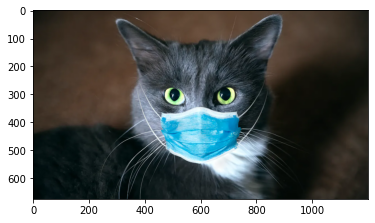

In [33]:
from matplotlib.pyplot import imread
img_path = 'catt.jpg'
img = image.load_img(img_path, target_size=(64,64))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print("Input image shape: ", x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))